# Libraries

In [24]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Model logged without a signature and input example")

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
import mlflow
from mlflow import log_metric, log_param
from sklearn.dummy import DummyClassifier
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, fbeta_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import time

# Dataset

## Import

In [43]:
data = pd.read_csv('Home_credit_risk_data_modeling.csv')

In [44]:
data.head(2)

,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df = data.iloc[:,1:] #delete first column 'unnamed:0'

In [65]:
df.head(2)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df.set_index('SK_ID_CURR', inplace = True)
df.head(2)

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df_size = df.shape

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 100002 to 456250
Columns: 796 entries, TARGET to CC_COUNT
dtypes: bool(133), float64(606), int64(41), object(16)
memory usage: 1.8+ GB


In [71]:
#replace infinite values by Nan
df.replace([np.inf, -np.inf], np.nan, inplace = True)

In [72]:
df.isna().sum()

TARGET                               48744
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
CNT_CHILDREN                             0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     252693
CC_NAME_CONTRACT_STATUS_nan_MEAN    252693
CC_NAME_CONTRACT_STATUS_nan_SUM     252693
CC_NAME_CONTRACT_STATUS_nan_VAR     253385
CC_COUNT                            252693
Length: 796, dtype: int64

Split the Dataset into a train (where target was informed) and test (where no target was informed)

In [73]:
df_train_sample = df.loc[~(df['TARGET'].isnull())]
df_test_sample = df.loc[df['TARGET'].isnull()]

In [74]:
del df
gc.collect() 

1318

In [75]:
print(f"Train dataset has {round((df_train_sample[df_train_sample['TARGET'] == 1].shape[0])/df_train_sample.shape[0]*100,1)}% of target 1 and {round((df_train_sample[df_train_sample['TARGET'] == 0].shape[0])/df_train_sample.shape[0]*100,1)}% of target 0")

Train dataset has 8.1% of target 1 and 91.9% of target 0


## Preprocessing

In [76]:
X = df_train_sample.drop(columns = ['TARGET']).copy()
y = df_train_sample['TARGET'].copy()

In [77]:
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''

    numerical_list = list()
    numerical_discrete_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            numerical_discrete_list.append(name)
        else:
            numerical_list.append(name)
    return numerical_list, numerical_discrete_list

In [78]:
numerical_list, numerical_disc_list = list_features_att(X)

Use of SimpleImputer to impute missing values:

In [79]:
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_list])
#imputation on  discrete numeric columns with 'most_frequent' strategy
X[numerical_disc_list] = SimpleImputer(strategy='most_frequent').fit_transform(X[numerical_disc_list])
print (f'time for imputation: {time.time() - time_init:.2f}')

time for imputation: 128.69


## Import / Export csv

In [49]:
# Use the first time to export as csv
#X.to_csv('./X_train_data.csv')
#y.to_csv('./y_train_data.csv')

# Import csv of all data
X = pd.read_csv('X_train_data.csv', index_col='SK_ID_CURR')
y = pd.read_csv('y_train_data.csv', index_col='SK_ID_CURR')

In [50]:
# for a better efficiency, we only try our models on 5% of train data
X1,_,y1,_ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=42)

In [51]:
# Use the first time to export as csv
X1.to_csv('./X_sample_train_data.csv')
y1.to_csv('./y_sample_train_data.csv')

# Import csv of sampled data before second split train/test and normalization
#X1 = pd.read_csv('X_sample_train_data.csv', index_col='SK_ID_CURR')
#y1 = pd.read_csv('y_sample_train_data.csv', index_col='SK_ID_CURR')

In [52]:
# data split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, train_size=0.8, shuffle= True, stratify= y1, random_state= 42)

In [53]:
# Normalization
std_scaler = StandardScaler()

std_scaler.fit(X1_train)
X1_train = std_scaler.transform(X1_train)
X1_test = std_scaler.transform(X1_test)

# MLFlow setup

In [6]:
# Set the MLFlow tracking URI (local file storage)
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("Credit Default Risk")

<Experiment: artifact_location='file:///Users/pctest/Desktop/Projet_7/mlruns/490746585877511176', creation_time=1731075992961, experiment_id='490746585877511176', last_update_time=1731075992961, lifecycle_stage='active', name='Credit Default Risk', tags={}>

# Modelisation

## Custom Metric

In [135]:
def weighted_metric(y_true, y_pred, scale=10):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix components
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    fn_penalty = 10  # False Negative penalty
    fp_penalty = 1   # False Positive penalty

    # Calculate the penalty score
    penalty_score = (fp * fp_penalty) + (fn * fn_penalty)

    score = 1 - (penalty_score / len(y_true) / 10000)

    return max(0, score)


# Use the metric with scikit-learn models
custom_scorer = make_scorer(weighted_metric, greater_is_better=True)

In [119]:
type(custom_scorer)

sklearn.metrics._scorer._Scorer

## Baseline Model: Dummy Classifier

In [120]:
# Define strategies and other parameters
strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
test_scores = []
train_scores = []
# Initialize an empty list to store results
results_list = []

In [121]:
for s in strategies:
    with mlflow.start_run(run_name=f"DummyClassifier_{s}"):
        # Log the strategy as a parameter
        log_param("strategy", s)
        
        # Initialize classifier based on strategy
        if s == 'constant':
            dclf = DummyClassifier(strategy=s, random_state=42, constant=0)
        else:
            dclf = DummyClassifier(strategy=s, random_state=42)
        
        # Track start time and fit the model
        start_time = time.time()
        dclf.fit(X1_train, y1_train)
        train_time = time.time() - start_time
        log_param("train_time", train_time)
        
        # Make predictions and calculate metrics
        y_pred1 = dclf.predict(X1_test)
        y_pred_proba = dclf.predict_proba(X1_test)[:, 1]  # Probability for the positive class

        # Calculate metrics
        score_test = dclf.score(X1_test, y1_test)  # mean accuracy
        test_scores.append({f'{s}': score_test})

        # Ensure y1_test and y_pred are numpy arrays
        y1_test = np.array(y1_test)
        y_pred1 = np.array(y_pred1)
        
        f1 = f1_score(y1_test, y_pred1)
        precision = precision_score(y1_test, y_pred1)
        recall = recall_score(y1_test, y_pred1)
        accuracy = accuracy_score(y1_test, y_pred1)
        roc_auc = roc_auc_score(y1_test, y_pred_proba)
        fbeta = fbeta_score(y1_test, y_pred1, beta=2)
        custom_score = weighted_metric(y1_test, y_pred1)

        # Log metrics to MLflow
        log_metric("accuracy", accuracy)
        log_metric("F1_score", f1)
        log_metric("precision", precision)
        log_metric("recall", recall)
        log_metric("ROC_AUC", roc_auc)
        log_metric("fbeta_score", fbeta)
        log_metric("custom_score", custom_score)
        
        # Print result for quick view
        result = {
            'model': 'Dummy_Classifier',
            'strategy': s,
            'F1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'ROC_AUC': roc_auc,
            'fbeta_score': fbeta,
            'custom_score': custom_score,
            'train_time': train_time
        }

        # Append the dictionary to the list
        results_list.append(result)
        mlflow.end_run()

In [122]:
# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame as a table
results_df

,model,strategy,F1_score,precision,recall,accuracy,ROC_AUC,fbeta_score,custom_score,train_time
0,Dummy_Classifier,most_frequent,0.000000,0.000000,0.000000,0.919350,0.500000,0.000000,0.752000,0.004191
1,Dummy_Classifier,stratified,0.095618,0.094488,0.096774,0.852358,0.507708,0.096308,0.749134,0.001762
2,Dummy_Classifier,uniform,0.145928,0.084868,0.520161,0.508943,0.500000,0.256768,0.734847,0.001877
3,Dummy_Classifier,constant,0.000000,0.000000,0.000000,0.919350,0.500000,0.000000,0.752000,0.001203


In [92]:
print(test_scores)

[{'most_frequent': 0.9193495934959349}, {'stratified': 0.8523577235772358}, {'uniform': 0.5089430894308943}, {'constant': 0.9193495934959349}]


Results are not great, same as randomness. But this is our baseline model so it is not surprising.

## Pipeline 

In [123]:
# Classification - Model Pipeline
def modelPipeline(X_train, X_test, y_train, y_test, step1):
    rs = {'random_state': 42}
    log_reg = LogisticRegression(**rs)
    nb = BernoulliNB()
    knn = KNeighborsClassifier()
    dt = DecisionTreeClassifier(**rs)
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs)

    clfs = [
            ('Logistic Regression', log_reg),
            ('Naive Bayes', nb),
            ('K-Nearest Neighbors', knn),
            ('Decision Tree', dt),
            ('Random Forest', rf),
            ('XGBoost', xgb),
            ('LGBMClassifier', lgbm)
    ]
    
    if step1 == 'over':
        Imb_Method = SMOTE(random_state=42)
        Imb_Method_label = "SMOTE"
    elif step1 == 'under':
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy='majority')
        Imb_Method_label = "RandomUnderSampler"

    pipelines = []
    scores_df = pd.DataFrame(columns=['Model', 'F1_Score', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC', 'fbeta_Score',
                                      'train_time', 'Imbalanced_method'])


    for clf_name, clf in clfs:
        with mlflow.start_run(run_name=clf_name):
            # Log model parameters and imbalance method
            mlflow.log_param("Model", clf_name)
            mlflow.log_param("Imbalanced_method", "SMOTE" if step1 == 'over' else "RandomUnderSampler")

            # Define and fit the pipeline
            pipe = Pipeline(steps=[
                ('step1', Imb_Method),
                ('classifier', clf)
            ])
            start_time = time.time()
            pipe.fit(X_train, y_train)
            train_time = time.time() - start_time

            # Log training time
            mlflow.log_metric("train_time", train_time)

            # Predictions and metrics
            y_pred = pipe.predict(X_test)
            y_pred_proba = pipe.predict_proba(X_test)[:, 1]

            # Compute metrics
            fscore = skm.f1_score(y_test, y_pred)
            pres = skm.precision_score(y_test, y_pred)
            rcall = skm.recall_score(y_test, y_pred)
            accu = skm.accuracy_score(y_test, y_pred)
            roc_auc = skm.roc_auc_score(y_test, y_pred_proba)
            fbeta = skm.fbeta_score(y_test, y_pred, beta=2)
            custom_score = weighted_metric(y_test, y_pred)

            # Log metrics to MLflow
            log_metric("accuracy", accuracy)
            log_metric("F1_score", f1)
            log_metric("precision", precision)
            log_metric("recall", recall)
            log_metric("ROC_AUC", roc_auc)
            log_metric("fbeta_score", fbeta)
            log_metric("custom_score", custom_score)

            # Log the trained model
            mlflow.sklearn.log_model(pipe, clf_name)

            # Store pipeline and results
            pipelines.append(pipe)

            # Append results to scores_df
            new_row = {
                'Model': clf_name,
                'F1_Score': fscore,
                'Precision': pres,
                'Recall': rcall,
                'Accuracy': accu,
                'ROC_AUC': roc_auc,
                'fbeta_Score': fbeta,
                'custom_score': custom_score,
                'train_time': train_time,
                'Imbalanced_method': Imb_Method_label
            }
            scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)

            mlflow.end_run()

    return pipelines, scores_df


In [124]:
def classifier_compare(df_gr):
    df_gr.sort_values(["custom_score", "ROC_AUC"], inplace=True)
    ax = df_gr[["custom_score","ROC_AUC","Precision","Recall", "Accuracy", "Model"]].plot(kind="line", x="Model", figsize=(19,5), title="Classifier Performance Sorted by Custom Metric")
    ax.legend()
    for p in ax.patches:
        ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

    ax.title.set_size(20)
    plt.box(False)
    df_gr.sort_values("train_time", inplace=True)
    ax= df_gr[["train_time","Model"]].plot(kind="line", x="Model", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
    ax.title.set_size(20)
    ax.legend(["Train Time"])
    plt.box(False)


## SMOTE without CV

We have a problem with our target data that are imbalanced (91/9 ratio), here we will use SMOTE to simulate an oversampling for the target 1.

In [125]:
_,scores_without_CV_SMOTE = modelPipeline(X1_train,X1_test,y1_train, y1_test, 'over')

2024/11/08 21:54:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/var/folders/f7/1t0gd_nj48d85_3rv7fqxdbh0000gn/T/ipykernel_20059/1951182335.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
2024/11/08 21:54:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/08 21:54:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging

In [136]:
scores_without_CV_SMOTE.sort_values('custom_score', ascending=False)

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method,custom_score
4,Random Forest,0.015873,0.500000,0.008065,0.919350,0.662661,0.010040,33.557586,SMOTE,0.751955
6,LGBMClassifier,0.081181,0.478261,0.044355,0.919024,0.737839,0.054187,13.702454,SMOTE,0.751740
5,XGBoost,0.098592,0.388889,0.056452,0.916748,0.719144,0.068093,18.658025,SMOTE,0.751594
3,Decision Tree,0.149254,0.126761,0.181452,0.833171,0.535897,0.167038,11.788817,SMOTE,0.747994
0,Logistic Regression,0.240458,0.157500,0.508065,0.741138,0.691820,0.351562,3.489008,SMOTE,0.742972
1,Naive Bayes,0.165946,0.105611,0.387097,0.686179,0.573972,0.252499,1.120254,SMOTE,0.741742
2,K-Nearest Neighbors,0.147627,0.082840,0.677419,0.369106,0.531131,0.278146,0.614984,SMOTE,0.729115


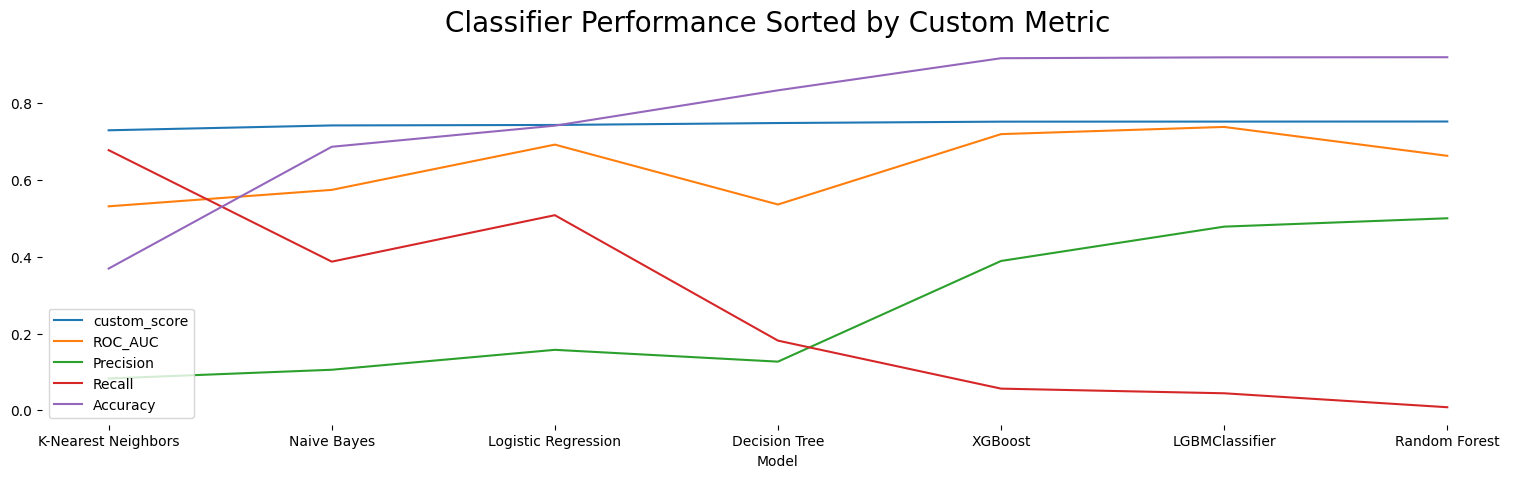

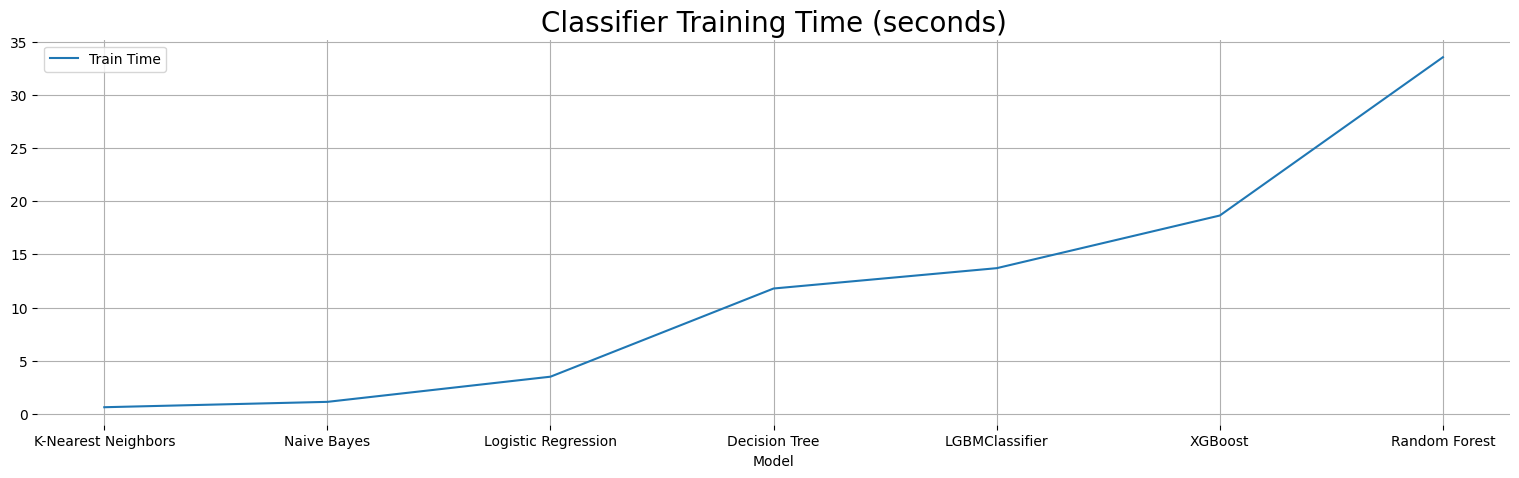

In [127]:
classifier_compare(scores_without_CV_SMOTE)

## RANDOM UNDER SAMPLER Without CV

In [137]:
_,scores_without_CV_RUS = modelPipeline(X1_train,X1_test,y1_train, y1_test, 'under')

2024/11/08 22:02:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/var/folders/f7/1t0gd_nj48d85_3rv7fqxdbh0000gn/T/ipykernel_20059/1951182335.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)
2024/11/08 22:02:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/08 22:02:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging

In [138]:
scores_without_CV_RUS.sort_values('custom_score', ascending=False)

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method,custom_score
6,LGBMClassifier,0.236939,0.144914,0.649194,0.662764,0.728768,0.382786,3.365290,RandomUnderSampler,0.739463
4,Random Forest,0.244364,0.149068,0.677419,0.662114,0.718367,0.396413,2.155303,RandomUnderSampler,0.739282
5,XGBoost,0.243302,0.148279,0.677419,0.660163,0.727383,0.395294,3.724084,RandomUnderSampler,0.739215
0,Logistic Regression,0.235129,0.142252,0.677419,0.644553,0.691482,0.386562,0.839475,RandomUnderSampler,0.738673
1,Naive Bayes,0.184573,0.111296,0.540323,0.614959,0.595901,0.305100,0.226715,RandomUnderSampler,0.738413
2,K-Nearest Neighbors,0.158496,0.095085,0.475806,0.592520,0.549090,0.264219,0.069078,RandomUnderSampler,0.737996
3,Decision Tree,0.186503,0.109986,0.612903,0.568780,0.588907,0.320135,0.787717,RandomUnderSampler,0.736405


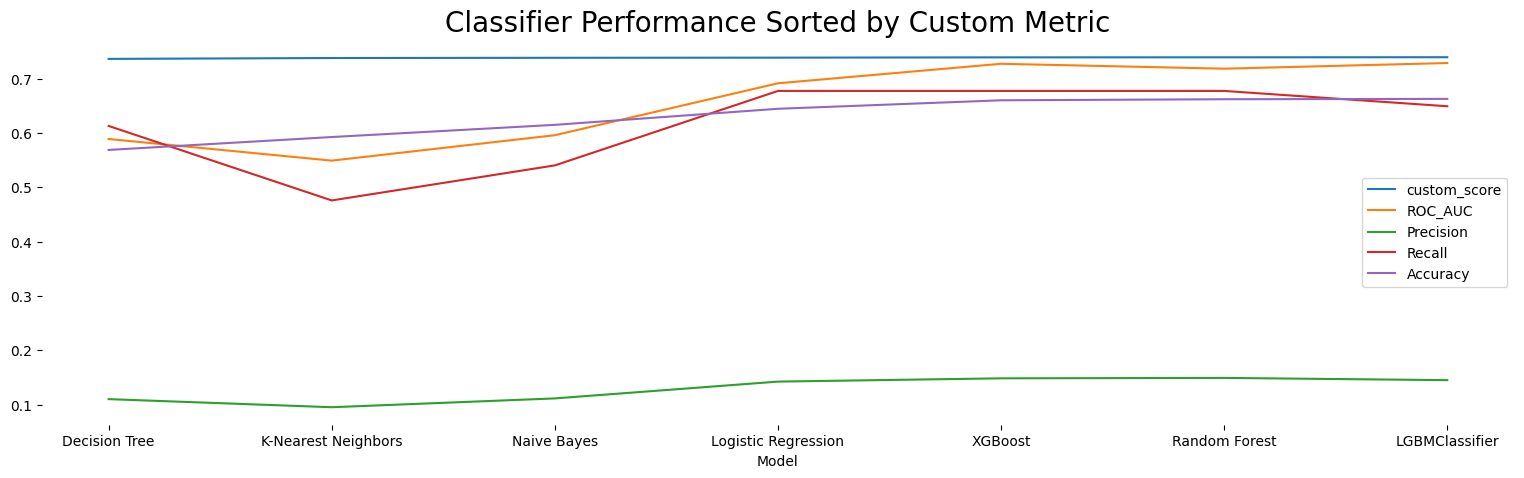

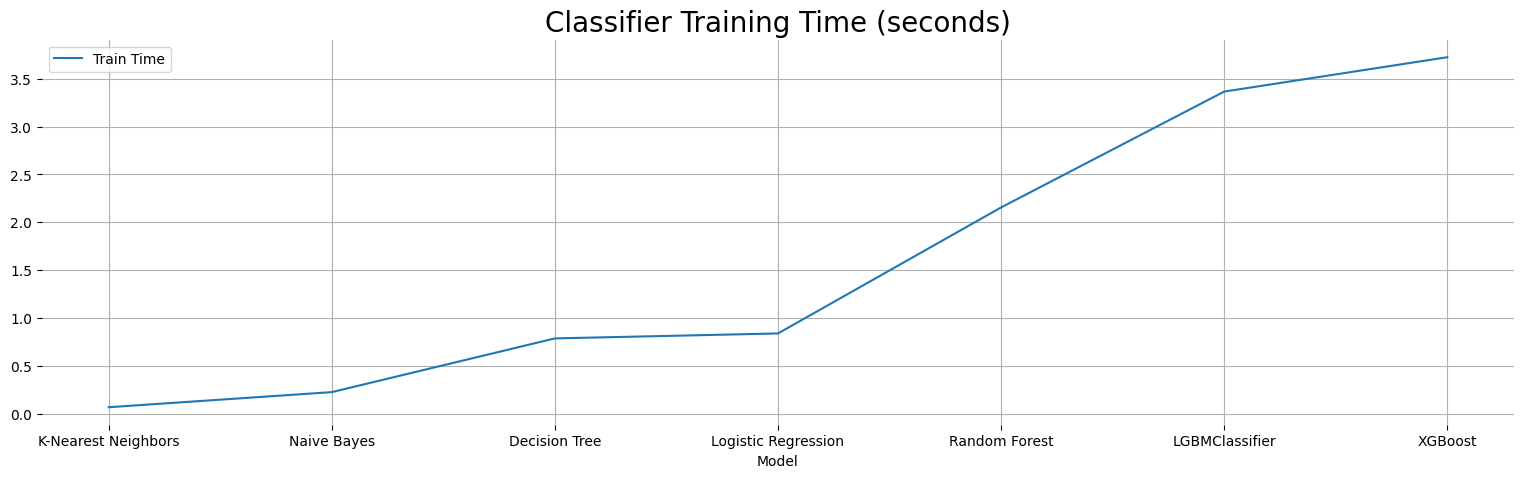

In [139]:
classifier_compare(scores_without_CV_RUS)

In [140]:
df_scores_sans_CV = pd.concat([scores_without_CV_SMOTE, scores_without_CV_RUS], ignore_index=True)
df_scores_sans_CV.sort_values('custom_score', ascending = False)

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method,custom_score
6,Random Forest,0.015873,0.500000,0.008065,0.919350,0.662661,0.010040,33.557586,SMOTE,0.751955
4,LGBMClassifier,0.081181,0.478261,0.044355,0.919024,0.737839,0.054187,13.702454,SMOTE,0.751740
5,XGBoost,0.098592,0.388889,0.056452,0.916748,0.719144,0.068093,18.658025,SMOTE,0.751594
3,Decision Tree,0.149254,0.126761,0.181452,0.833171,0.535897,0.167038,11.788817,SMOTE,0.747994
2,Logistic Regression,0.240458,0.157500,0.508065,0.741138,0.691820,0.351562,3.489008,SMOTE,0.742972
1,Naive Bayes,0.165946,0.105611,0.387097,0.686179,0.573972,0.252499,1.120254,SMOTE,0.741742
12,LGBMClassifier,0.236939,0.144914,0.649194,0.662764,0.728768,0.382786,3.365290,RandomUnderSampler,0.739463
11,Random Forest,0.244364,0.149068,0.677419,0.662114,0.718367,0.396413,2.155303,RandomUnderSampler,0.739282
13,XGBoost,0.243302,0.148279,0.677419,0.660163,0.727383,0.395294,3.724084,RandomUnderSampler,0.739215
10,Logistic Regression,0.235129,0.142252,0.677419,0.644553,0.691482,0.386562,0.839475,RandomUnderSampler,0.738673


LGBMClassifier, XGBoost and Random Forest are the three best models, using SMOTE as imbalanced method.

## Pipeline CV

In [173]:
def modelPipelineGrid(X_train, X_test, y_train, y_test, step1):
    scores_Cv = []
    rs = {'random_state': 42}
    rf = RandomForestClassifier(**rs)
    xgb = XGBClassifier(**rs, verbosity=0)
    lgbm = LGBMClassifier(**rs, verbosity=0)

    # Define parameter grids
    
    xgb_params = {
        'n_estimators': [50, 100],           # Limited number of boosting rounds
        'max_depth': [3, 6],                 # Small to moderate depth
        'learning_rate': [0.1, 0.3]           # Fixed colsample to avoid overfitting
    }
    random_params = {
        'n_estimators': [50, 100],            # Moderate values for the number of trees
        'max_depth': [10, 20, None],          # A couple of depth values plus unlimited depth
        'max_features': ['sqrt', 'log2']      # Feature selection for each split
    }
    lgbm_params = {
        'n_estimators': [50, 100],           # Moderate values to keep training fast
        'max_depth': [5, 10],                # Control depth to prevent overfitting
        'learning_rate': [0.1, 0.3],         # Moderate learning rates
    }

    # Define classifiers and their parameter grids
    clfs = [
        ('XGBoost', xgb, xgb_params),
        ('LGBMClassifier', lgbm, lgbm_params),
        ('Random Forest', rf, random_params),
    ]

    # Define sampling method based on `step1`
    if step1 == 'over':
        Imb_Method = SMOTE(random_state=42)
        Imb_Method_label = "SMOTE"
    elif step1 == 'under':
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy='majority')
        Imb_Method_label = "RandomUnderSampler"


    for clf_name, clf, param_grid in clfs:
        # Start an MLflow run for each model
        with mlflow.start_run(run_name=clf_name):
            # Log the model name and sampling method
            mlflow.log_param("Model", clf_name)
            mlflow.log_param("Imbalanced Method", "SMOTE" if step1 == 'over' else "RandomUnderSampler")

            # Define the pipeline
            pipe = Pipeline(steps=[
                ('step1', Imb_Method),
                ('classifier', clf)
            ])

            # Set up GridSearchCV with the parameter grid
            search = GridSearchCV(pipe, {f'classifier__{param}': values for param, values in param_grid.items()},
                                  cv=3, scoring= 'roc_auc')
            
            # Fit the grid search
            search.fit(X_train, y_train)
            
            # Log the best parameters and best score
            mlflow.log_params(search.best_params_)
            mlflow.log_metric("Best Score ROC AUC", search.best_score_)
            mlflow.log_metric("Refit Time", search.refit_time_)

            # Log the best model as an artifact
            mlflow.sklearn.log_model(search.best_estimator_, artifact_path=clf_name)

            # Append results to scores_Cv
            scores_Cv.append({
                'model': clf_name,
                'best_score ROC_AUC': search.best_score_,
                'best parameters': search.best_params_,
                'Best model': search.best_estimator_,
                'Refit Time': search.refit_time_,
                'Imb Method': Imb_Method_label
            })

            # End the MLflow run
            mlflow.end_run()

    return scores_Cv


## SMOTE GrisdSearchCV

In [174]:
scores_with_CV_SMOTE = modelPipelineGrid(X1_train, X1_test, y1_train, y1_test, 'over')

ValueError: Invalid parameter 'learning_rate' for estimator Pipeline(steps=[('step1', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
df_scores_with_CV_SMOTE = pd.DataFrame(scores_with_CV_SMOTE)
df_scores_with_CV_SMOTE

## RUS GridSearchCV

In [146]:
scores_with_CV_RUS = modelPipelineGrid(X1_train, X1_test, y1_train, y1_test, 'under')

2024/11/08 22:23:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2024/11/08 22:24:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/08 22:24:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [147]:
df_scores_with_CV_RUS = pd.DataFrame(scores_with_CV_RUS)
df_scores_with_CV_RUS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time,Imb Method
0,XGBoost,0.734066,"{'classifier__learning_rate': 0.1, 'classifier...","(RandomUnderSampler(random_state=42, sampling_...",1.440076,RandomUnderSampler
1,LGBMClassifier,0.723216,"{'classifier__learning_rate': 0.1, 'classifier...","(RandomUnderSampler(random_state=42, sampling_...",2.476226,RandomUnderSampler
2,Random Forest,0.708697,"{'classifier__max_depth': 10, 'classifier__max...","(RandomUnderSampler(random_state=42, sampling_...",1.588853,RandomUnderSampler


In [155]:
df_scores_with_CV = pd.concat([df_scores_with_CV_RUS, df_scores_with_CV_SMOTE], ignore_index=True)
df_scores_with_CV.sort_values('best_score ROC_AUC', ascending = False, inplace=True)

In [160]:
df_scores_with_CV

,model,best_score ROC_AUC,best parameters,Best model,Refit Time,Imb Method
0,XGBoost,0.734066,"{'classifier__learning_rate': 0.1, 'classifier...","(RandomUnderSampler(random_state=42, sampling_...",1.440076,RandomUnderSampler
4,LGBMClassifier,0.730829,"{'classifier__learning_rate': 0.1, 'classifier...","(SMOTE(random_state=42), LGBMClassifier(max_de...",12.129405,SMOTE
3,XGBoost,0.730294,"{'classifier__learning_rate': 0.1, 'classifier...","(SMOTE(random_state=42), XGBClassifier(base_sc...",24.746328,SMOTE
1,LGBMClassifier,0.723216,"{'classifier__learning_rate': 0.1, 'classifier...","(RandomUnderSampler(random_state=42, sampling_...",2.476226,RandomUnderSampler
2,Random Forest,0.708697,"{'classifier__max_depth': 10, 'classifier__max...","(RandomUnderSampler(random_state=42, sampling_...",1.588853,RandomUnderSampler
5,Random Forest,0.693343,"{'classifier__max_depth': 20, 'classifier__max...","(SMOTE(random_state=42), (DecisionTreeClassifi...",32.331796,SMOTE


In [162]:
best_param_xgb_rus = df_scores_with_CV.iloc[0, 2]
best_param_xgb_rus

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100}

In [163]:
best_param_lgbm_smote = df_scores_with_CV.iloc[1, 2]
best_param_lgbm_smote

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 10,
 'classifier__n_estimators': 100}

## Final Pipeline

In [175]:
# Classification - Model Pipeline
def finalPipeline(X_train, X_test, y_train, y_test):
    rs = {'random_state': 42}
    xgb = XGBClassifier(**rs, learning_rate = 0.1, max_depth = 3, n_estimators = 100, verbosity=0)
    lgbm = LGBMClassifier(**rs, learning_rate = 0.1, max_depth = 10, n_estimators = 100)

    clfs = [
            ('XGBoost', xgb),
            ('LGBMClassifier', lgbm)
    ]

    pipelines = []
    scores_df = pd.DataFrame(columns=['Model', 'F1_Score', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC', 'fbeta_Score',
                                      'train_time', 'Imbalanced_method'])


    for clf_name, clf in clfs:
        with mlflow.start_run(run_name=clf_name):
            # Log model parameters and imbalance method
            mlflow.log_param("Model", clf_name)

            if clf == lgbm:
                print('lgbm')
                Imb_Method = SMOTE(random_state=42)
                Imb_Method_label = "SMOTE"
                mlflow.log_param("Imbalanced_method", "SMOTE")
            else:
                print('xgb')
                Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy='majority')
                Imb_Method_label = "RandomUnderSampler"
                mlflow.log_param("Imbalanced_method","RandomUnderSampler")
            
            # Define and fit the pipeline
            pipe = Pipeline(steps=[
                ('step1', Imb_Method),
                ('classifier', clf)
            ])
            start_time = time.time()
            pipe.fit(X_train, y_train)
            train_time = time.time() - start_time

            # Log training time
            mlflow.log_metric("train_time", train_time)

            # Predictions and metrics
            y_pred = pipe.predict(X_test)
            y_pred_proba = pipe.predict_proba(X_test)[:, 1]

            # Compute metrics
            fscore = skm.f1_score(y_test, y_pred)
            pres = skm.precision_score(y_test, y_pred)
            rcall = skm.recall_score(y_test, y_pred)
            accu = skm.accuracy_score(y_test, y_pred)
            roc_auc = skm.roc_auc_score(y_test, y_pred_proba)
            fbeta = skm.fbeta_score(y_test, y_pred, beta=2)
            custom_score = weighted_metric(y_test, y_pred)

            # Log metrics to MLflow
            log_metric("accuracy", accuracy)
            log_metric("F1_score", f1)
            log_metric("precision", precision)
            log_metric("recall", recall)
            log_metric("ROC_AUC", roc_auc)
            log_metric("fbeta_score", fbeta)
            log_metric("custom_score", custom_score)

            # Log the trained model
            mlflow.sklearn.log_model(pipe, clf_name)

            # Store pipeline and results
            pipelines.append(pipe)

            # Append results to scores_df
            new_row = {
                'Model': clf_name,
                'F1_Score': fscore,
                'Precision': pres,
                'Recall': rcall,
                'Accuracy': accu,
                'ROC_AUC': roc_auc,
                'fbeta_Score': fbeta,
                'custom_score': custom_score,
                'train_time': train_time,
                'Imbalanced_method': Imb_Method_label
            }
            scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)

            mlflow.end_run()

    return pipelines, scores_df

In [176]:
_, final_results = finalPipeline(X1_train,X1_test,y1_train, y1_test)

xgb


2024/11/08 23:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/var/folders/f7/1t0gd_nj48d85_3rv7fqxdbh0000gn/T/ipykernel_20059/2521708242.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([new_row])], ignore_index=True)


lgbm


2024/11/08 23:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [177]:
df_final_results = pd.DataFrame(final_results)
df_final_results

,Model,F1_Score,Precision,Recall,Accuracy,ROC_AUC,fbeta_Score,train_time,Imbalanced_method,custom_score
0,XGBoost,0.252239,0.154762,0.681452,0.674146,0.748606,0.405470,8.570423,RandomUnderSampler,0.739677
1,LGBMClassifier,0.115108,0.533333,0.064516,0.920000,0.729312,0.078278,15.035304,SMOTE,0.751661


## Best Models

In [202]:
model_uri_2 = 'runs:/ea73c313693c48bd81d7aeeae0873dac/XGBoost'

In [ ]:
run_id = "9ee51113168a456eba285b139b6781bf"
model_uri = f"runs:/{run_id}/LGBMClassifier"

In [194]:
best_model = mlflow.sklearn.load_model(model_uri)

In [195]:
best_model

Pipeline(steps=[('step1', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(classifier__learning_rate=0.1,
                                classifier__max_depth=10,
                                classifier__n_estimators=100,
                                random_state=42))])

In [203]:
best_model_xgb = mlflow.sklearn.load_model(model_uri_2)

In [196]:
best_model.fit(X1_train, y1_train)
y_pred = best_model.predict(X1_test)
cf_matrix = confusion_matrix(y1_test, y_pred)

[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__n_estimators


In [197]:
cf_matrix

array([[2815,   12],
       [ 237,   11]])

In [205]:
best_model_xgb.fit(X1_train, y1_train)
y_pred_xgb = best_model_xgb.predict(X1_test)
cf_matrix_xgb = confusion_matrix(y1_test, y_pred_xgb)

In [206]:
cf_matrix_xgb

array([[1862,  965],
       [  80,  168]])

In [200]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(9, 7))
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='nipy_spectral')
 
    plt.title("Prédiction avec les données normalisées")
    plt.show()

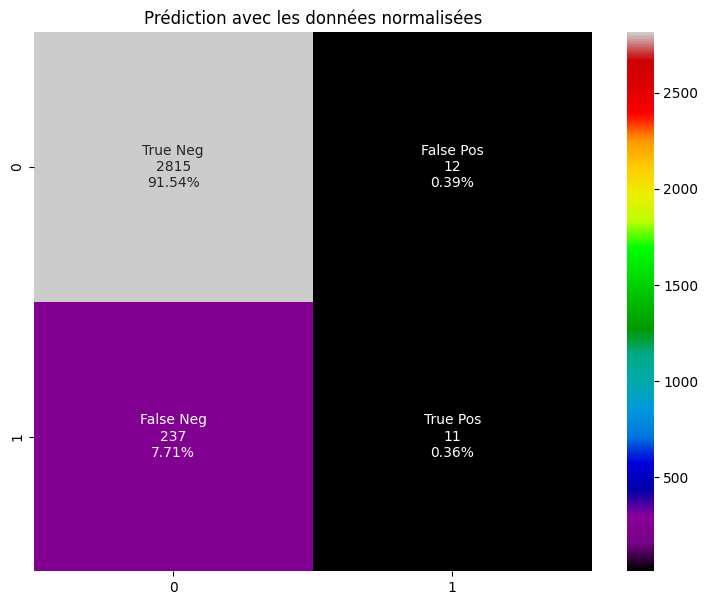

In [201]:
plot_confusion_matrix(cf_matrix)

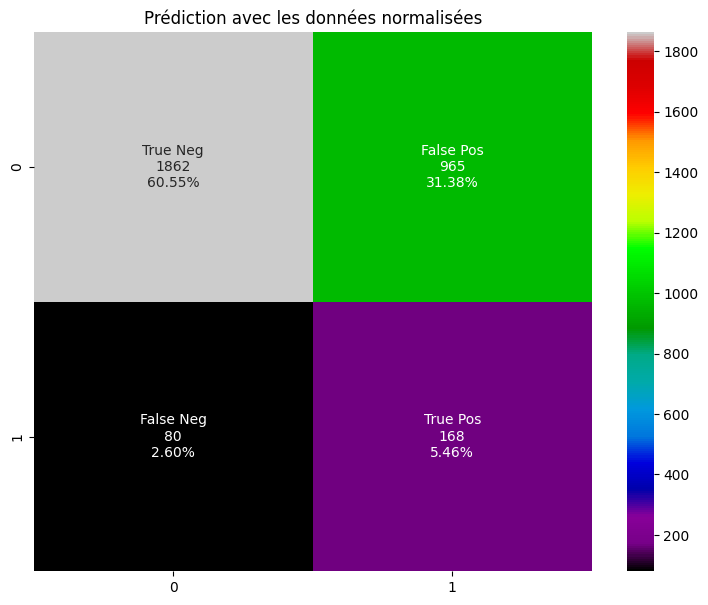

In [207]:
plot_confusion_matrix(cf_matrix_xgb)

# Feature Importance

In [215]:
shap_values = shap.TreeExplainer(best_model.named_steps['classifier']).shap_values(X1_test)

In [216]:
#exemple with one feature:
shap.dependence_plot("EXT_SOURCE_2", shap_values[1], X1_test,feature_names=X1.columns)

IndexError: index 31 is out of bounds for axis 1 with size 1

In [218]:
shap_values[1]

array([-7.54619594e-01, -1.21860831e-01, -2.17154221e-01, -2.25435089e-02,
       -4.17441340e-02,  6.21961941e-02,  1.39834308e-02,  7.74898696e-02,
        1.19996981e-02, -6.49044357e-02, -5.71618336e-03,  3.02452477e-02,
       -9.31857894e-02, -6.87175183e-05,  0.00000000e+00, -2.32881716e-03,
       -2.18854750e-02,  0.00000000e+00, -4.24019270e-02,  0.00000000e+00,
        6.79193101e-05, -3.63121073e-04, -1.99080656e-02,  2.00742391e-02,
       -2.50109425e-04,  0.00000000e+00, -3.87940006e-05, -5.05607767e-04,
       -3.94432060e-02, -7.30753169e-03,  7.25567567e-03,  1.65688567e-01,
       -2.57666804e-01, -5.71068356e-05,  1.03606461e-03,  9.83867635e-03,
        0.00000000e+00, -4.03911166e-03, -4.11410568e-03, -1.75688498e-03,
        6.55561095e-04, -7.71314599e-03, -2.83016723e-04,  1.40619681e-03,
       -2.41325963e-03,  0.00000000e+00, -6.28933418e-04, -1.00156224e-04,
        1.31706730e-03, -5.42273430e-04, -2.19430861e-04,  7.46660201e-05,
        0.00000000e+00, -